## Gradients computation
The goal of this notebook is to compute gradient of a function $f : x \to y$ where $x\in\mathbb{R}^d$ and $y\in\mathcal{M}$ with $\mathcal{M}$ associated with a Riemannian metric. 

The gradient $\nabla f $ is obtained by first considering $ df : T_{x} \mathbb{R}^d \to  T_{f(x)} \mathcal{M}  $. where $T_{.}$ is a tangent space.

For any tangent vector $v \in T_{x} \mathbb{R}^d $, the gradient $\nabla f \in T_{f(x)} \mathcal{M}$ is represented using the partial derivatives and the pushforward under $f$:

$$ df(v) = \sum_{j}^{d} \frac{\partial f}{\partial x^{j}} v^{j} $$

The Riemannian metric (that defines a norm on the tangent vectors) can then be used to measure the norm of this gradient.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys 
sys.path.append("/Users/pozzolabadmin/Documents/codebase/experiments/peptide_phase_mapping")
from utils import plot_phasemap
import torch 
from math import pi
from torch.distributions import Normal, Uniform
torch.set_default_dtype(torch.double)

In [2]:
# Example Hilbert space: Functions in L2 norm approximated on a grid
t = np.linspace(0, 2*pi, 100)

def funct(x):
    tt = torch.from_numpy(t).view(1, 100).repeat(x.shape[0], 1)  # Discretized Hilbert space
    T1 = x[:,0].view(x.shape[0], 1)*torch.sin(tt)
    T2 = x[:,1].view(x.shape[0], 1)*torch.cos(tt)
    return T1+ T2

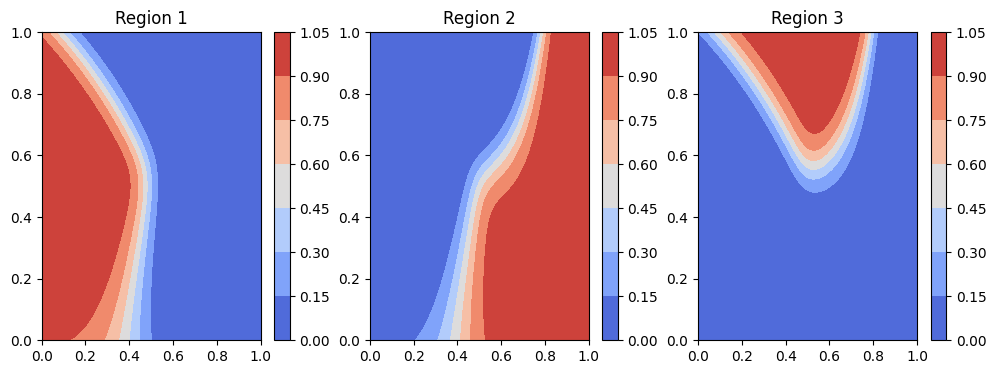

In [3]:
def gaussian_2d(x, y, mean, cov):
    """
    Computes the 2D Gaussian probability density function (PDF).

    Parameters:
        x (Tensor): x-coordinates.
        y (Tensor): y-coordinates.
        mean (Tensor): Mean of the Gaussian (2D vector).
        cov (Tensor): Covariance matrix (2x2).

    Returns:
        Tensor: Probability density values at (x, y).
    """
    pos = torch.stack([x, y], dim=-1)  # Shape: (..., 2)
    mean = mean.unsqueeze(0)  # Ensure broadcasting
    cov_inv = torch.inverse(cov)
    diff = pos - mean

    exponent = -0.5 * torch.sum(diff @ cov_inv * diff, dim=-1)
    norm_factor = torch.sqrt((2 * torch.pi) ** 2 * torch.det(cov))
    pdf = torch.exp(exponent) / norm_factor
    return pdf

def probability_map(x, y, means, covariances):
    """
    Assigns probabilities to a point in 2D space for three Gaussian regions.

    Parameters:
        x (Tensor): x-coordinates of the points.
        y (Tensor): y-coordinates of the points.
        means (Tensor): Means of the Gaussian regions (3x2).
        covariances (Tensor): Covariance matrices of the regions (3x2x2).

    Returns:
        Tensor: Probabilities of belonging to each region (shape: Nx3).
    """
    num_regions = means.shape[0]
    probabilities = []

    for i in range(num_regions):
        pdf = gaussian_2d(x, y, means[i], covariances[i])
        probabilities.append(pdf)

    probabilities = torch.stack(probabilities, dim=-1)  # Shape: (..., 3)
    probabilities /= probabilities.sum(dim=-1, keepdim=True)  # Normalize to sum to 1
    return probabilities

# Example Usage

# Define 2D Gaussian parameters
means = torch.tensor([[0.3, 0.5], [0.7, 0.5], [0.5, 0.8]])  # Centers of the regions
covariances = torch.stack([
    torch.tensor([[0.01, 0.0], [0.0, 0.02]]),  # Region 1 covariance
    torch.tensor([[0.02, 0.01], [0.01, 0.02]]),  # Region 2 covariance
    torch.tensor([[0.01, -0.005], [-0.005, 0.02]])  # Region 3 covariance
])

# Sample points
x = torch.linspace(0, 1, 100)
y = torch.linspace(0, 1, 100)
X, Y = torch.meshgrid(x, y, indexing="ij")
probabilities = probability_map(X.flatten(), Y.flatten(), means, covariances)

# Reshape probabilities for visualization
probabilities = probabilities.reshape(100, 100, 3)

# Visualize the probabilities
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
phases = ["Region 1", "Region 2", "Region 3"]
for i, ax in enumerate(axs):
    c = ax.contourf(X.numpy(), Y.numpy(), probabilities[:, :, i].numpy(), cmap="coolwarm")
    ax.set_title(phases[i])
    plt.colorbar(c, ax=ax)
plt.show()


In [4]:
t = np.linspace(0, 1, 100)

def gaussian_peak_curve(t, n_peaks):
    out = torch.zeros_like(t)
    for i in range(1, n_peaks+1):
        dist = Normal(torch.tensor(1.0, requires_grad=True), 
                    torch.tensor(0.1, requires_grad=True)
                    )
        zi = dist.mean  # Use the mean instead of rsample() for differentiability
        mu = (2 * i - 1) / (2 * 3)
        std = 1 / (3 * 3)
        factor = 1 / (2 * (std ** 2))
        phi = torch.exp(-factor * (t - mu) ** 2)
        out += zi * phi  
        
    return out

In [5]:

def gaussian_peak_three_phase(c):
    """
    Computes a differentiable approximation of the original function.

    Parameters:
        c (Tensor): Input tensor of shape (2,) representing the parameters.

    Returns:
        Tensor: Output tensor with computed values.
    """
    # Define the time vector and phases
    tt = torch.linspace(0, 1, steps=len(t))
    c_ = c.squeeze()
    probabilities = probability_map(*c_, means, covariances).squeeze()

    # Generate a continuous parameter a
    dist = Uniform(-3.0, 3.0)
    a = dist.sample().requires_grad_()
    gam = (torch.exp(a * tt) - 1) / (torch.exp(a) - 1)

    # Precompute parameters for each label
    out = torch.zeros_like(gam)
    for i in range(1, 4):
        y = gaussian_peak_curve(gam, i)
        out += probabilities[i - 1] * y  # Weighted sum based on label probabilities

    return out

In [6]:
# Generate sparse samples in R^2
n_grid = 20
x_samples = torch.cartesian_prod(torch.linspace(0, 1, n_grid), 
                                 torch.linspace(0, 1, n_grid))
# y_samples = funct(x_samples)  # Corresponding outputs in Hilbert space
y_samples_torch = [gaussian_peak_three_phase(x) for x in x_samples]

In [7]:
y_samples = torch.stack(y_samples_torch).detach().numpy()

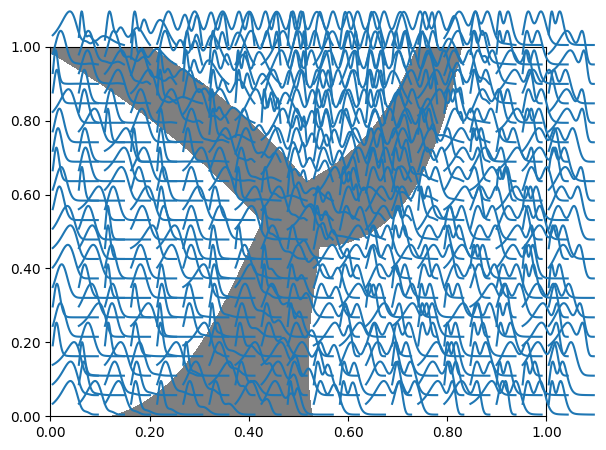

In [8]:
# Visualize function samples 
bounds = np.asarray([(0.0, 1.0), (0.0, 1.0)]).T 
fig, ax = plt.subplots()
plot_phasemap(bounds, ax, x_samples, y_samples)
for i in range(3):
    c = ax.contourf(X.numpy(), 
                    Y.numpy(), 
                    probabilities[:, :, i].numpy(), 
                    levels = [0.1, 0.7],
                    cmap="grey"
                    )
plt.show()

In [9]:
def l2_norm(x, fx, tangent_vectors):
    grad = torch.trapezoid(tangent_vectors**2, x=x, dim=0)
    grad_norm = grad.sum()

    return grad, grad_norm 

def compute_gradient(xt, f, norm):
    yt = f(xt).squeeze()
    df_dx = []
    for i in range(len(t)):  # Loop over t to compute gradient for each sample
        yt[i].backward(retain_graph=True)  # Retain graph for multiple backward calls
        df_dx.append(xt.grad.clone())  # Store the gradients
        xt.grad.zero_()  # Reset gradients for next computation

    df_dx = torch.stack(df_dx).squeeze()  # Stack gradients for all t
    tangent_vectors = xt*df_dx
    grad, grad_norm = norm(yt, tangent_vectors)

    return tangent_vectors, grad, grad_norm

In [10]:
from funcshape.functions import Function
def fisher_rao_norm(x, fx, tv):
    ft = Function(x, fx.reshape(-1,1))
    vt_x1 = Function(x, tv[:,0].reshape(-1,1))
    vt_x2 = Function(x, tv[:,1].reshape(-1,1))
    scale = torch.sqrt(torch.abs(ft.derivative(x)) + 1e-3)
    srsf = torch.stack((vt_x1.derivative(x)/scale , vt_x2.derivative(x)/scale)).squeeze().T

    grad = 0.25*torch.trapezoid(srsf**2, x=x, dim=0)
    grad_norm = grad.sum()

    return grad, grad_norm

In [11]:
from apdist.geometry import SquareRootSlopeFramework as SRSF

def weighted_amplitude_phase(x, y_ref, y_query, **kwargs):
    srsf = SRSF(x)
    q_ref = srsf.to_srsf(y_ref)
    q_query = srsf.to_srsf(y_query)
    gamma = srsf.get_gamma(q_ref, q_query, **kwargs)

    delta = q_ref-q_query
    if delta.sum() == 0:
        amplitude, phase = 0.0, 0.0
    else:
        gam_dev = np.gradient(gamma, srsf.time)
        q_gamma = np.interp(gamma, srsf.time, q_query)
        y_amplitude = (q_ref - (q_gamma * np.sqrt(gam_dev))) ** 2

        amplitude = np.sqrt(np.trapz(y_amplitude, srsf.time))

        p_gamma = np.sqrt(gam_dev)*y_ref # we define p(\gamma) = \sqrt{\dot{\gamma(t)}} * f(t)
        p_identity = np.ones_like(gam_dev)*y_ref
        y_phase =  (p_gamma - p_identity) ** 2

        phase = np.sqrt(np.trapz(y_phase, srsf.time))

    return amplitude, phase

def finite_difference(f, c, eps=1e-3):
    f_grad = []
    for i in range(len(c)):
        perturb = torch.zeros_like(c)
        perturb[i] = eps
        f_plus = f(c + perturb)  
        f_minus = f(c - perturb) 
        # Central difference approximation of the derivative
        amplitude, phase = weighted_amplitude_phase(t, 
                                      f_plus.detach().numpy() , 
                                      f_minus.detach().numpy()
                                      ) 
        f_grad.append((amplitude+phase)/ (4 * eps + 1e-3))

    return torch.Tensor(f_grad)

### Compute FD gradients

In [12]:
example_idx = np.random.randint(0, x_samples.shape[0])
xt = x_samples[example_idx,:]
grad = finite_difference(gaussian_peak_three_phase, xt)

In [13]:
fd_grad_norms_grid = torch.zeros(x_samples.shape[0])
fd_grad_grid = torch.zeros(x_samples.shape[0], 2)
for i in range(x_samples.shape[0]):
    grad_xi = finite_difference(gaussian_peak_three_phase, x_samples[i,:], eps=1/20)
    fd_grad_norms_grid[i] = torch.linalg.vector_norm(grad_xi)
    fd_grad_grid[i,...] = grad_xi

### Compute manifold gradients

In [14]:
example_idx = np.random.randint(0, x_samples.shape[0])
xt = x_samples[example_idx,:].view(1,2).clone().detach().requires_grad_(True)
norm = lambda fx, tv : fisher_rao_norm(torch.from_numpy(t), fx, tv)
tangent_vectors, grad, grad_norm_numerical = compute_gradient(xt, gaussian_peak_three_phase, norm)

In [15]:
x_norm = torch.linalg.norm(xt)
norm_analytic = (x_norm**2)*pi # for the funct using l2 norm
print(norm_analytic, grad_norm_numerical)

tensor(1.1313, grad_fn=<MulBackward0>) tensor(17.0823, grad_fn=<SumBackward0>)


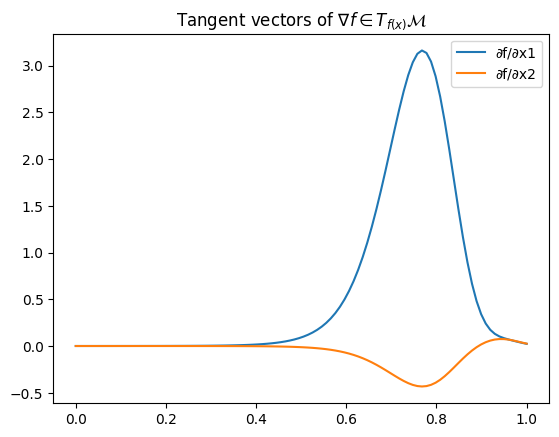

In [16]:
fig, ax = plt.subplots()
for dim, label in zip(range(2), ["x1", "x2"]):
    ax.plot(t, tangent_vectors[:, dim].detach(), label=f"∂f/∂{label}")
ax.legend()
ax.set_title(r"Tangent vectors of $\nabla f \in T_{f(x)} \mathcal{M}$")
plt.show()

In [17]:
manifold_grad_norms_grid = torch.zeros(x_samples.shape[0])
tangent_vectors_grid = torch.zeros((x_samples.shape[0], 100, 2))
manifold_grad_grid = torch.zeros(x_samples.shape[0], 2)
for i in range(x_samples.shape[0]):
    xi = x_samples[i,:].view(1,2).clone().detach().requires_grad_(True)
    tangent_vectors_xi, grads_xi, grad_norms_xi = compute_gradient(xi, gaussian_peak_three_phase, norm)
    manifold_grad_norms_grid[i] = grad_norms_xi
    tangent_vectors_grid[i,...] = tangent_vectors_xi 
    manifold_grad_grid[i,...] = grads_xi

In [91]:
from matplotlib.colors import PowerNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap

def plot_gradient_field_contours(grad_grid, grad_norms_grid):
    fig, ax = plt.subplots()

    # Add contour plot with colors
    norm=PowerNorm(gamma=2)
    z = np.log(np.abs(grad_norms_grid.detach().numpy()+1e-5))
#     norm = Normalize(vmin=min(z), vmax=max(z))
    cmap = "jet"
    ax.tricontourf(x_samples[:,0], 
                x_samples[:,1], 
                z,
                norm = norm,
                cmap = cmap
                )
    mappable = ScalarMappable(norm=norm, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.2)
    cbar = fig.colorbar(mappable,shrink=0.5, aspect=5,cax=cax)
    cbar.ax.set_ylabel('gradient norm (normalized)', rotation=90)
    cbar.set_ticks(np.linspace(z.min(), z.max(), 5))

    # Add quivers
    U = grad_grid[:,0]
    V = grad_grid[:,1]

    ax.quiver(x_samples[:,0], 
            x_samples[:,1], 
            U.detach(), 
            V.detach(), 
            color="k",
            lw=2.0,
            units='width'
            )

    plt.show()

In [83]:
def plot_gradient_field_scatter(grad_grid, grad_norms_grid):
        fig, ax = plt.subplots()

        # Add scatter plot
        ax.scatter(x_samples[:,0], 
                x_samples[:,1], 
                s = grad_norms_grid.detach(),
                color="k"
                )

        # Add quivers
        U = grad_grid[:,0]
        V = grad_grid[:,1]

        # Normalize the arrows:
        norm = torch.sqrt(U**2 + V**2)
        U = U / norm
        V = V / norm
        ax.quiver(x_samples[:,0], 
                x_samples[:,1], 
                U.detach(), 
                V.detach(), 
                color="tab:red",
                lw=2.0,
                units='width'
                )

        plt.show()

### Finite Differences

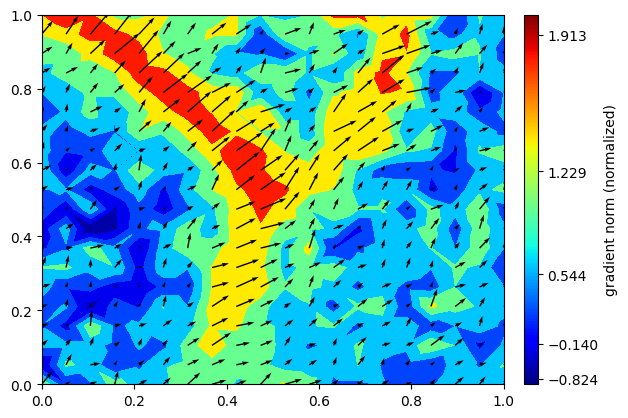

In [92]:
plot_gradient_field_contours(fd_grad_grid, fd_grad_norms_grid)

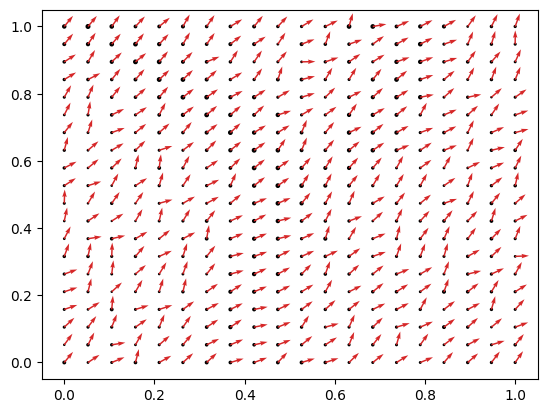

In [85]:
plot_gradient_field_scatter(fd_grad_grid, fd_grad_norms_grid)

### Manifold function gradients

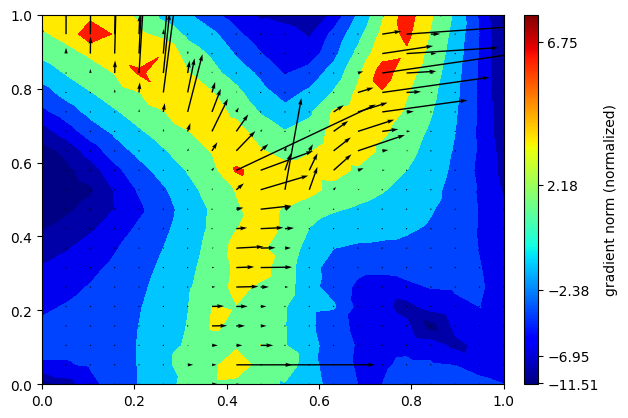

In [93]:
plot_gradient_field_contours(manifold_grad_grid, manifold_grad_norms_grid)

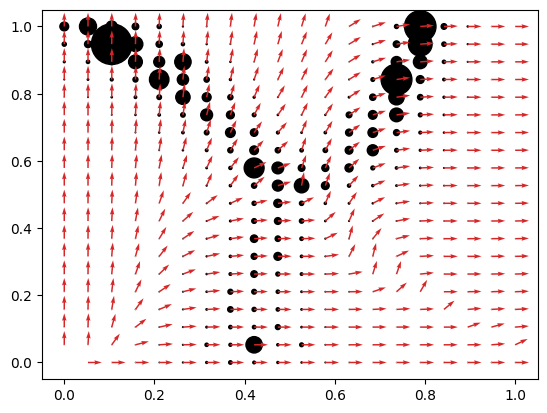

In [87]:
plot_gradient_field_scatter(manifold_grad_grid, manifold_grad_norms_grid)

In [24]:
# fig, ax = plt.subplots(figsize=(10,10))
# ax.scatter(x_samples[:,0], x_samples[:,1])
# for i in range(x_samples.shape[0]):
#     label = "%.1f"%grad_norms_grid[i].detach()
#     ax.text(x_samples[i,0], 
#             x_samples[i,1],
#             label 
#             )
# plt.show()

In [27]:
def phasemap_gradient(xy):
    """A function to compute gradient at any given composition.

    xy : a tuple corresponding to a 2D composition.
    """
    global grads 
    global num_fevals
    c1, c2 = xy
    comp_np = np.array([c1, c2])
    # for some reason only the following can track the gradient of x
    # not directly creating the tensor using torch.tensor
    comp_tensor = torch.from_numpy(comp_np)
    x = comp_tensor.clone().detach().requires_grad_(True)

    norm = lambda fx, tv : fisher_rao_norm(torch.from_numpy(t), fx, tv)
    _, grad, grad_norm = compute_gradient(x, gaussian_peak_three_phase, norm)
    grads.append(grad.detach().cpu().squeeze().numpy())
    print("Evaluated function for the %d-th time"%num_fevals, end="\r", flush=True)
    num_fevals += 1
    return grad_norm.detach().cpu().squeeze().numpy()

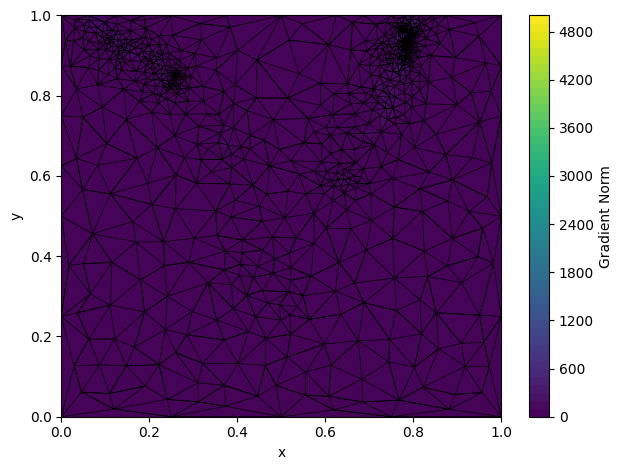

In [31]:
# Collective adaptive samples from the phasemap
import adaptive
from scipy.spatial import Delaunay

grads = []
num_fevals = 0
design_space_bounds = [(0.0, 1.0), (0.0, 1.0)]
learner = adaptive.Learner2D(phasemap_gradient, design_space_bounds)
adaptive.runner.simple(learner, npoints_goal = 1000)
adaptive_samples_data = learner.to_numpy()
with torch.no_grad():
    tri = Delaunay(adaptive_samples_data[:,:2])

    fig, ax = plt.subplots()
    contour =  ax.tricontourf(adaptive_samples_data[:,0], 
                              adaptive_samples_data[:,1], 
                              adaptive_samples_data[:,-1],
                              levels=50
                              )
    plt.colorbar(contour, label="Gradient Norm")
    # ax.scatter(adaptive_samples_data[:,0], adaptive_samples_data[:,1], s=15, color="k")
    for simplex in tri.simplices:
        pts = tri.points[simplex]
        ax.plot(pts[:, 0], pts[:, 1], 'k-', lw=0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.tight_layout()
    plt.show()